### Procesamiento de Palabras

0. Agregar una columna que mide el porcentaje de inglés usado en el tweet  y ver con eso  cuántos son en inglés ( tweets que superan cierto threshold de inglés)
1. Diferenciar preguntas de afirmaciones (relacionar con el target)
2. Tweet “inutiles” (tweets sin palabras ingles, cosas raras)



In [10]:
#IMPORTS

import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys,os
%run ../datuslib.ipynb

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [11]:
N_df = pd.read_csv("../Data/train.csv")
N_df.text.isnull().sum() #no hay textos vacios

0

In [12]:
N_df['len_texts'] = N_df.text.map(lambda x: len(x))

In [13]:
N_df['porcentaje_de_ingles'] = N_df.text.map(lambda x: porcentajeDeIngles(x))

In [15]:
N_df

,id,keyword,location,text,target,len_texts,porcentaje_de_ingles
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,92.307692
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,57.142857
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,100.000000
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,85.714286
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,93.750000
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,85.714286
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,80.952381
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,53.846154
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,95.454545


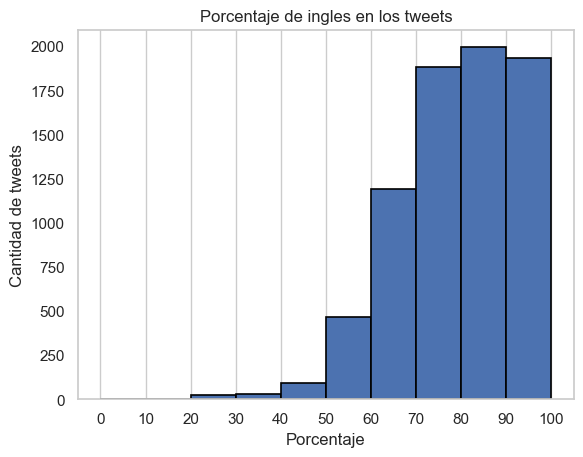

In [16]:
ax = plt.hist(N_df.porcentaje_de_ingles,color = 'b', bins = 10, edgecolor='black', linewidth=1.2)
plt.title("Porcentaje de ingles en los tweets", fontsize = 12)

tick = []
for i in range(0, 100+1, 10):
    tick.append(i)
plt.xticks(tick)

plt.xlabel('Porcentaje')
plt.ylabel('Cantidad de tweets')

plt.grid(which = 'major', axis = 'y')

True     7463
False     150
Name: tweets_en_ingles, dtype: int64

In [238]:
def encasillar_porcentaje(x): #encasillar los porcentajes de a 10%. 5 seria 50% o mas, y menos de 60%.
    c = x / 10
    return math.ceil(c)    
N_df['bins_porcentajes'] = N_df.porcentaje_de_ingles.map(lambda x: encasillar_porcentaje(x))

In [ ]:
''' Considerando que al menos un 50% del texto tiene que estar en ingles para que se considere que esta en ingles, podemos ver
cuantos textos vamos a rechazar, porque los textos que no esten en ingles no se podran analizar, ya que analizar textos
en todos los idiomas del mundo es sumamente complejo '''
N_df['tweets_en_ingles'] = N_df.porcentaje_de_ingles >= 50

In [ ]:
N_df.tweets_en_ingles.value_counts() #Solo se descartan 150 tweets, menos de un 0.02% de los tweets

In [ ]:
# 1. Diferenciar preguntas de afirmaciones (relacionar con el target)

# ANALISIS BASICO (Validez = 1 palabra en ingles)

¿Que constituye una pregunta? Un tweet que tenga al menos 1 palabra en ingles antes de un signo de pregunta.
¿Que constituye una afirmacion? Un tweet que tenga al menos 1 palabra en ingles.

In [9]:
df['textosValidos'] = df.text.map(lambda x: hasEnglishWord(x)) 

In [10]:
df = df[df.textosValidos]

In [14]:
df['esPregunta'] = df.text.map(lambda x: isQuestion(x))  

In [15]:
df['preguntasConDesastre'] = df.esPregunta & df.target
df['preguntasSinDesastre'] = df.esPregunta & (df.target.apply(lambda x: 1 if x == 0 else 0))

Text(0, 0.5, 'Name of Category')

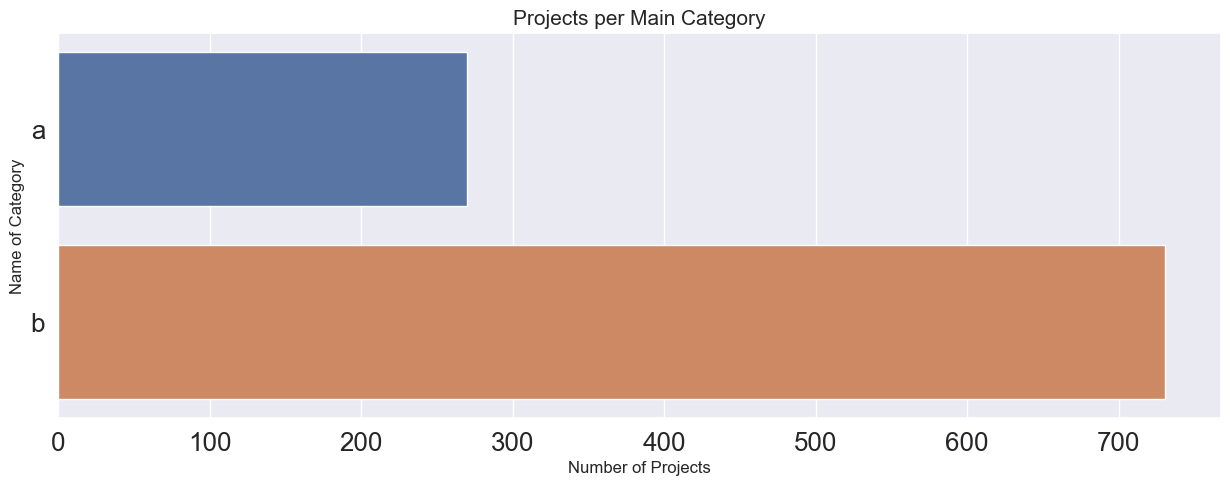

In [20]:
g = sns.barplot
(x=[df.preguntasConDesastre.sum(), df.preguntasSinDesastre.sum()], y=['a','b'], orient='h')
g.set_title("Projects per Main Category", fontsize=15)
g.set_xlabel("Number of Projects", fontsize=12)
g.set_ylabel("Name of Category", fontsize=12)